In [1]:
%matplotlib  inline

# Train a CNN classifier and compare Normalized Margin

We are going to train a basic CNN model with or without batch normalization. Margins (normalized) will be shown along the training. 

In [2]:
# -*- coding: utf-8 -*-
__author__ = 'huangyf'

In [2]:
import os
import sys
import pickle
import torch
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import basic_cnn
#from collections import OrderedDict #if import basic_cnn, this line can be dropped
from utils import AverageMeter, accuracy, get_margin

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

use_gpu = torch.cuda.is_available()

In [3]:
class CNN(nn.Module):
    def __init__(self, channels, output_size, with_bn=True):
        super(CNN, self).__init__()
        self.with_bn = with_bn
        self.features = self._make_layers(channels)
        self.classifier = nn.Linear(channels, output_size)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, channels):
        layers = []
        in_channels = 3
        for i in range(5):
            if i == 0:
                if self.with_bn:
                    layers += [('conv%d' % i, nn.Conv2d(in_channels, channels, 3, 2, 1)),
                               ('bn%d' % i, nn.BatchNorm2d(channels)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
                else:
                    layers += [('conv%d' % i, nn.Conv2d(in_channels, channels, 3, 2, 1)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
            else:
                if self.with_bn:
                    layers += [('conv%d' % i, nn.Conv2d(channels, channels, 3, 2, 1)),
                               ('bn%d' % i, nn.BatchNorm2d(channels)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
                else:
                    layers += [('conv%d' % i, nn.Conv2d(channels, channels, 3, 2, 1)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
        return nn.Sequential(OrderedDict(layers))

In [4]:
def train_model(model, criterion, optimizer, log_saver, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        margin = []

        for phase in ['train', 'test']:

            loss_meter = AverageMeter()
            acc_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[phase]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                inputs = Variable(inputs)
                labels = Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1
                    margin = np.append(margin, get_margin(outputs, labels))

                loss_meter.update(loss.data.item(), outputs.size(0))
                acc_meter.update(accuracy(outputs.data, labels.data)[-1].item(), outputs.size(0))

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin'].append(min(margin))
                ww = 1
                for i in range(6):
                    if i <= 4:
                        size = eval('model.features.conv%d.weight.size()' % i)
                        # here to compute the F norm between each CNN layer
                        w_norm = eval('model.features.conv%d.weight.view(size[0],-1).pow(2).sum(1).mean().data.item()' % i)
                        log_saver['w%d' % i].append(w_norm)
                    else:
                        w_norm = model.classifier.weight.norm(2).data.item()
                        log_saver['w_fc'].append(w_norm)
                    ww *= w_norm
                log_saver['normalised_margin'].append(log_saver['margin'][-1] / ww)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

            print('{} Loss: {:.4f} Error: {:.4f}'.format(
                phase, epoch_loss, epoch_error), end=' ' if phase == 'train' else '\n')
            if phase == 'train':
                print('w4_norm: {:.4f} Margin: {:.4f} Norm_margin: {:.4f}'.format(log_saver['w4'][-1],
                                                                                  log_saver['margin'][-1],
                                                                                  log_saver['normalised_margin'][-1]))

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {
                'net': model,
                'epoch': epoch,
                'log': log_saver
            }

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state, './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, log_saver


In [5]:
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])

In [6]:
training_dataset = datasets.CIFAR10(root, train=True, transform=img_transforms, download=True)
training_loader = DataLoader(training_dataset, BATCH_SIZE, shuffle=True, pin_memory=True)

testing_dataset = datasets.CIFAR10(root, train=False, transform=img_transforms)
testing_loader = DataLoader(testing_dataset, BATCH_SIZE, shuffle=False, pin_memory=True)

loaders = {'train': training_loader, 'test': testing_loader}

Files already downloaded and verified


In [8]:
log = {'num_params': [],
       'train_loss': [],
       'train_error': [],
       'test_loss': [],
       'test_error': [],
       'w0': [], 'w1': [], 'w2': [],
       'w3': [], 'w4': [], 'w_fc': [],
       'margin': [], 'normalised_margin': []}

In [9]:
# %% run the model
num_epochs = 100
channels = 100
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model, log = train_model(model, criterion, optimizer, log, num_epochs=num_epochs)


Epoch 1/100
----------
train Loss: 1.7692 Error: 0.6050 w4_norm: 0.3355 Margin: -4.3204 Norm_margin: -417.5935
test Loss: 1.5109 Error: 0.5199
Saving..
Epoch 2/100
----------
train Loss: 1.3686 Error: 0.4777 w4_norm: 0.3362 Margin: -5.7613 Norm_margin: -451.1701
test Loss: 1.2708 Error: 0.4480
Epoch 3/100
----------
train Loss: 1.1818 Error: 0.4137 w4_norm: 0.3372 Margin: -6.7085 Norm_margin: -451.9942
test Loss: 1.1502 Error: 0.4050
Epoch 4/100
----------
train Loss: 1.0397 Error: 0.3614 w4_norm: 0.3383 Margin: -6.7501 Norm_margin: -399.6846
test Loss: 1.0611 Error: 0.3708
Epoch 5/100
----------
train Loss: 0.9295 Error: 0.3233 w4_norm: 0.3395 Margin: -7.5038 Norm_margin: -394.4779
test Loss: 1.0122 Error: 0.3560
Epoch 6/100
----------
train Loss: 0.8429 Error: 0.2901 w4_norm: 0.3409 Margin: -7.9716 Norm_margin: -374.1303
test Loss: 0.9790 Error: 0.3432
Epoch 7/100
----------
train Loss: 0.7659 Error: 0.2623 w4_norm: 0.3424 Margin: -7.7868 Norm_margin: -327.1963
test Loss: 0.9875 Erro

test Loss: 1.7206 Error: 0.3296
Epoch 59/100
----------
train Loss: 0.0032 Error: 0.0001 w4_norm: 0.3747 Margin: -1.1653 Norm_margin: -7.3429
test Loss: 1.7190 Error: 0.3294
Epoch 60/100
----------
train Loss: 0.0030 Error: 0.0000 w4_norm: 0.3747 Margin: -1.1692 Norm_margin: -7.3540
test Loss: 1.7343 Error: 0.3308
Epoch 61/100
----------
train Loss: 0.0031 Error: 0.0000 w4_norm: 0.3748 Margin: -0.2869 Norm_margin: -1.8011
test Loss: 1.7463 Error: 0.3335
Saving..
Epoch 62/100
----------
train Loss: 0.0029 Error: 0.0000 w4_norm: 0.3748 Margin: -0.4079 Norm_margin: -2.5558
test Loss: 1.7621 Error: 0.3313
Epoch 63/100
----------
train Loss: 0.0030 Error: 0.0001 w4_norm: 0.3748 Margin: -2.0428 Norm_margin: -12.7767
test Loss: 1.7424 Error: 0.3322
Epoch 64/100
----------
train Loss: 0.0027 Error: 0.0000 w4_norm: 0.3748 Margin: -0.4760 Norm_margin: -2.9722
test Loss: 1.7432 Error: 0.3327
Epoch 65/100
----------
train Loss: 0.0026 Error: 0.0001 w4_norm: 0.3748 Margin: -0.6790 Norm_margin: -4.2

In [11]:
print('number-of-parameters:',log['num_params'])

number-of-parameters: [365210]


In [12]:
for name, param in model.named_parameters(): #for name, param in model.state_dict().items():
    if param.requires_grad:
        print('parameter_name:',name)

parameter_name: features.conv0.weight
parameter_name: features.conv0.bias
parameter_name: features.bn0.weight
parameter_name: features.bn0.bias
parameter_name: features.conv1.weight
parameter_name: features.conv1.bias
parameter_name: features.bn1.weight
parameter_name: features.bn1.bias
parameter_name: features.conv2.weight
parameter_name: features.conv2.bias
parameter_name: features.bn2.weight
parameter_name: features.bn2.bias
parameter_name: features.conv3.weight
parameter_name: features.conv3.bias
parameter_name: features.bn3.weight
parameter_name: features.bn3.bias
parameter_name: features.conv4.weight
parameter_name: features.conv4.bias
parameter_name: features.bn4.weight
parameter_name: features.bn4.bias
parameter_name: classifier.weight
parameter_name: classifier.bias


In [13]:
for name1, param1 in model.state_dict().items():
    print('parameter_name:',name1)

parameter_name: features.conv0.weight
parameter_name: features.conv0.bias
parameter_name: features.bn0.weight
parameter_name: features.bn0.bias
parameter_name: features.bn0.running_mean
parameter_name: features.bn0.running_var
parameter_name: features.conv1.weight
parameter_name: features.conv1.bias
parameter_name: features.bn1.weight
parameter_name: features.bn1.bias
parameter_name: features.bn1.running_mean
parameter_name: features.bn1.running_var
parameter_name: features.conv2.weight
parameter_name: features.conv2.bias
parameter_name: features.bn2.weight
parameter_name: features.bn2.bias
parameter_name: features.bn2.running_mean
parameter_name: features.bn2.running_var
parameter_name: features.conv3.weight
parameter_name: features.conv3.bias
parameter_name: features.bn3.weight
parameter_name: features.bn3.bias
parameter_name: features.bn3.running_mean
parameter_name: features.bn3.running_var
parameter_name: features.conv4.weight
parameter_name: features.conv4.bias
parameter_name: fe

In [14]:
print('model.features.bn0.weight:\n',model.features.bn0.weight,'\n model.features.bn0.running_var_sqrt:\n',model.features.bn0.running_var.sqrt()+1e-5)

model.features.bn0.weight:
 Parameter containing:
tensor([ 0.5141,  0.2458,  0.0399,  0.7638,  1.0393,  0.2392,  0.2622,
         0.8857,  0.7465,  0.7134,  0.7274,  0.7462,  0.7184,  0.8952,
         0.1241,  0.3848,  0.4175,  0.5174,  0.7753,  0.7031,  0.1691,
         0.2233,  0.6128,  0.2872,  0.2331,  0.3117,  0.4290,  0.4004,
         0.9463,  0.4026,  0.1957,  0.8642,  0.0414,  0.8541,  0.9122,
         0.6549,  0.3269,  0.0728,  0.7086,  0.5966,  0.1242,  0.2936,
         0.5764,  0.0459,  0.8909,  0.5366,  0.6128,  0.9151,  0.7924,
         0.0457,  0.0880,  0.4669,  0.4097,  0.2017,  0.8894,  0.6508,
         0.2872,  0.3410,  0.8156,  0.6731,  0.6172,  0.0410,  0.7544,
         0.3080,  0.7403,  0.0930,  0.8935,  0.0245,  0.5331,  0.9550,
         0.9828,  0.8357,  0.4982,  0.6163,  0.8243,  0.8910,  0.5453,
         0.9601,  0.7976,  0.7104,  0.9737,  0.3597,  0.2054,  0.1782,
         0.6000,  0.8133,  0.5716,  0.6064,  0.7290,  0.8436,  0.7904,
         0.8604,  0.8924,  

In [15]:
print('\gamma/(\sqrt{Var_run}+\eps):\n',
      model.features.bn0.weight/(model.features.bn0.running_var.sqrt()+1e-5))

$\gamma/(\sqrt{Var_run}+\eps)$:
 tensor([ 1.8544,  0.2758,  0.0539,  2.2892,  1.9724,  0.8548,  0.4341,
         1.5874,  1.9705,  2.1422,  0.9925,  1.6219,  1.2548,  2.3108,
         0.3215,  0.7505,  0.8570,  0.7092,  1.8478,  1.6145,  0.5800,
         0.4301,  1.0525,  0.3719,  0.2686,  0.3153,  0.8979,  0.7258,
         2.3123,  0.9014,  0.2644,  2.0780,  0.0480,  1.6260,  1.5985,
         1.5415,  0.4927,  0.1486,  2.8258,  1.1711,  0.2567,  0.6165,
         2.4055,  0.0468,  1.4712,  1.0369,  1.3729,  2.0346,  1.7831,
         0.0392,  0.0738,  1.4949,  1.6293,  0.9984,  1.7014,  2.3428,
         1.2504,  0.5640,  1.4236,  2.4872,  1.6920,  0.0392,  2.6380,
         0.9182,  2.3724,  0.1230,  1.8216,  0.0656,  1.3630,  1.7700,
         1.8193,  1.1688,  1.7209,  1.4326,  1.6144,  1.9118,  1.4546,
         1.6958,  1.9769,  1.6924,  2.2331,  0.8274,  0.3798,  0.3403,
         1.2223,  2.1697,  2.9807,  1.8971,  2.0414,  3.0815,  2.8686,
         1.7352,  1.9969,  0.1623,  0.5592, 

# (Yuan YAO): 

we need to compute the weight (gamma) and standard deviation 
(features.bn.running_var.sqrt()? epsilon here?) for batch normalization layers.

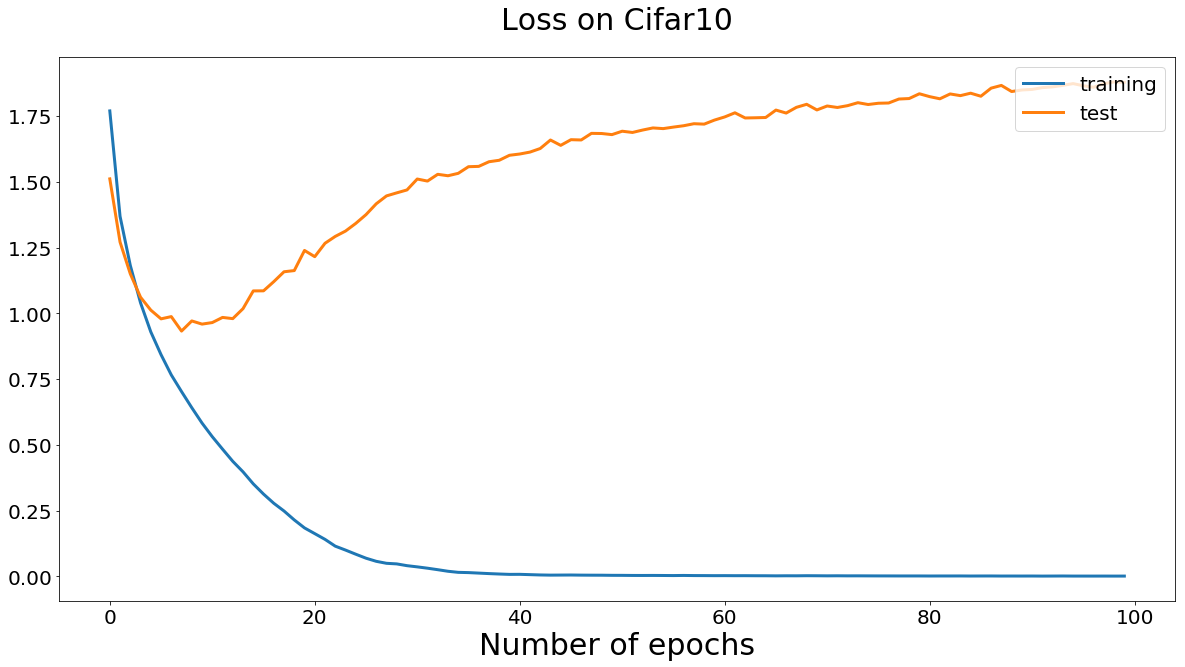

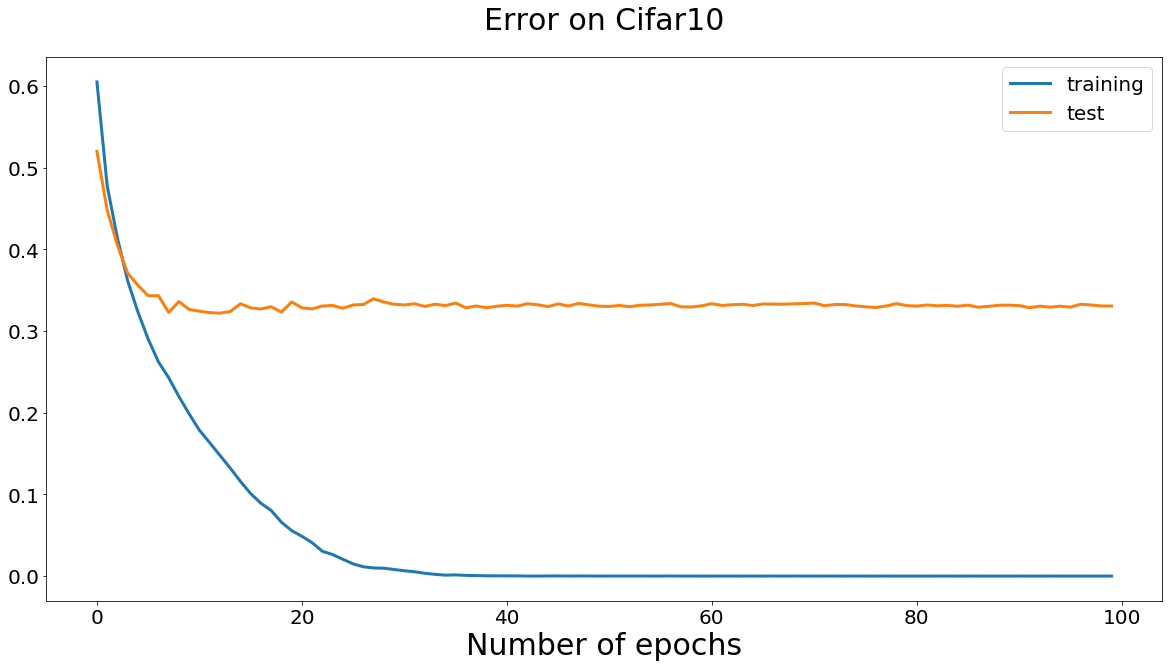

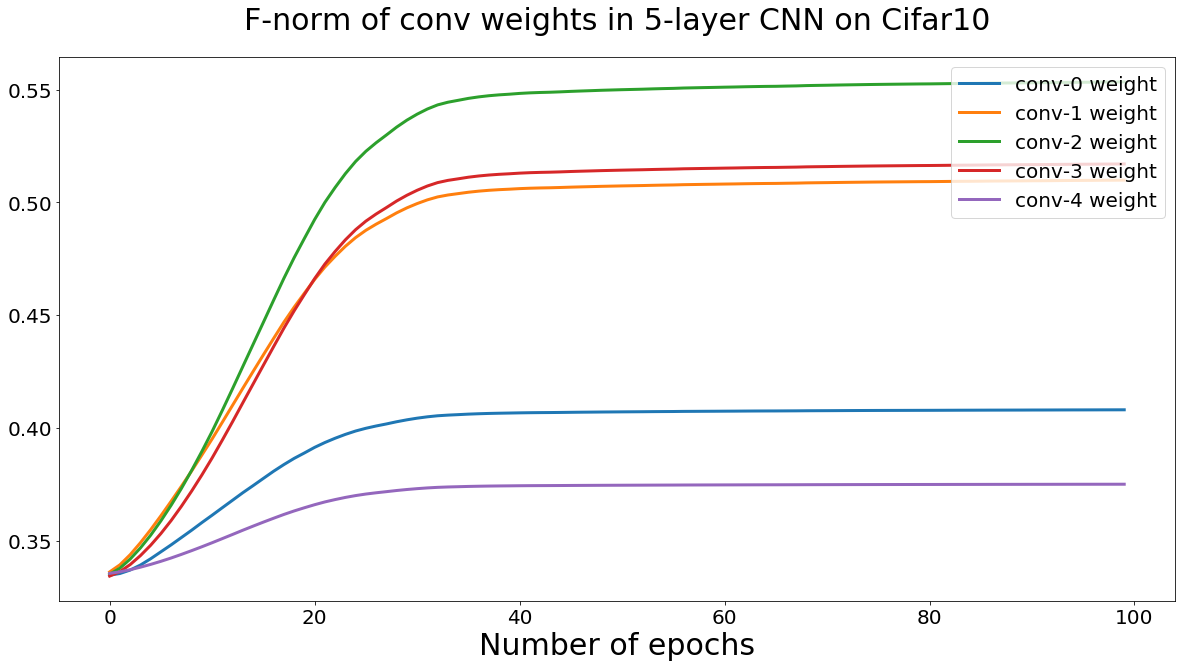

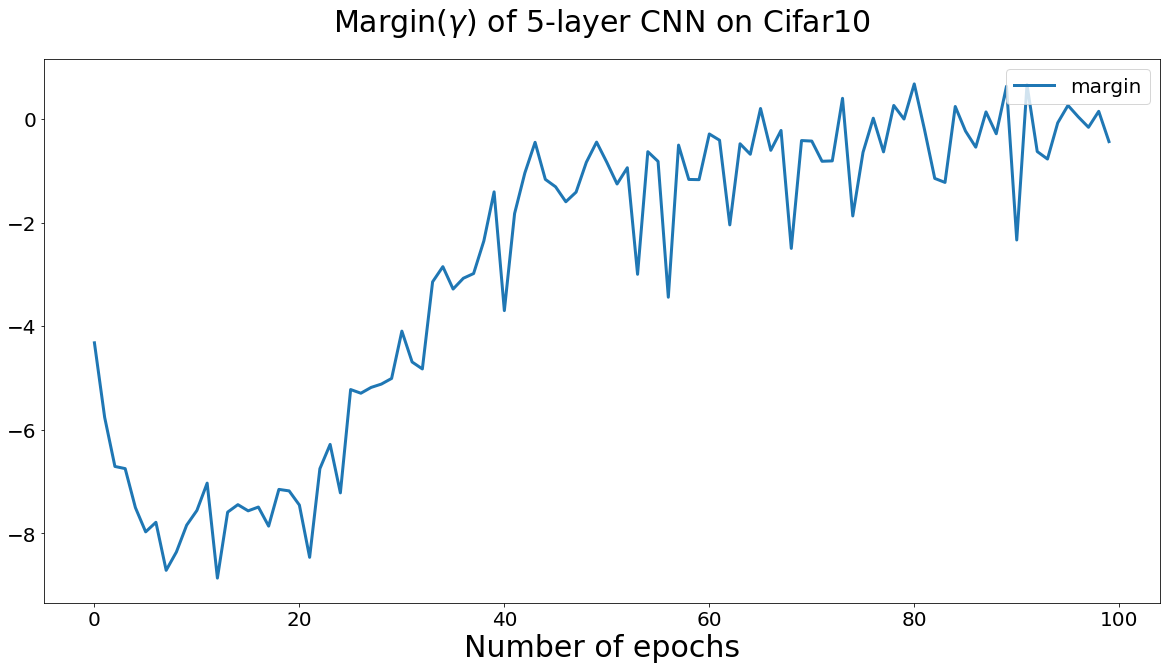

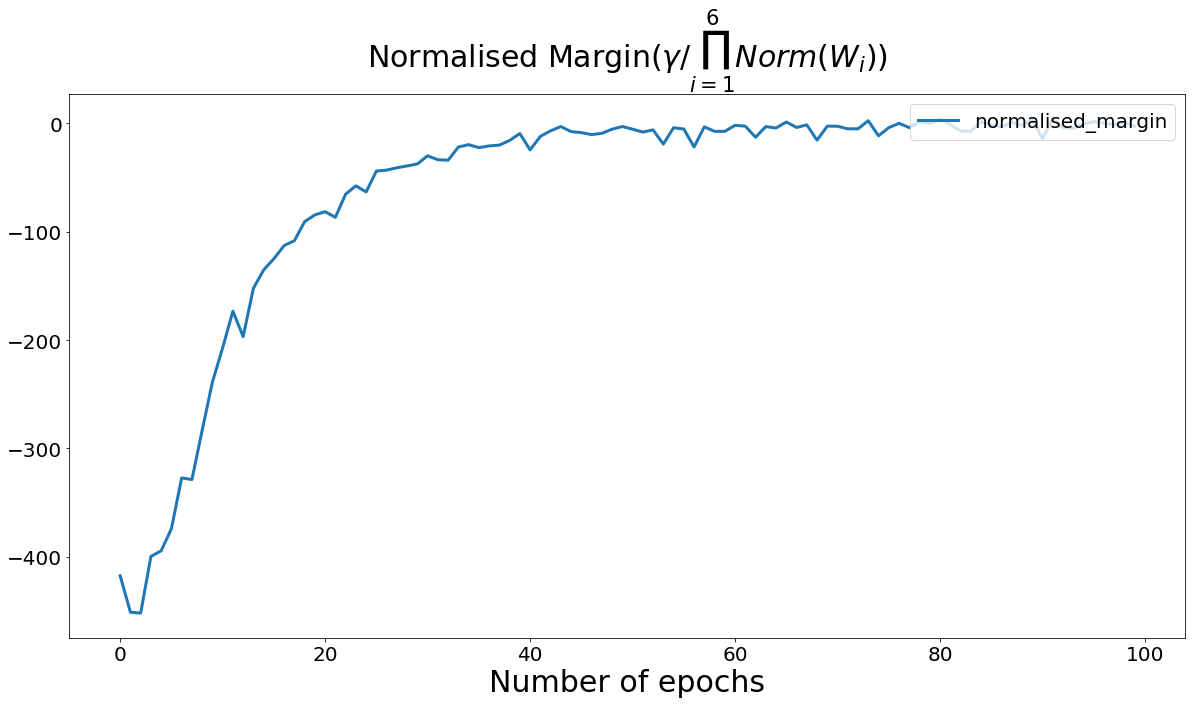

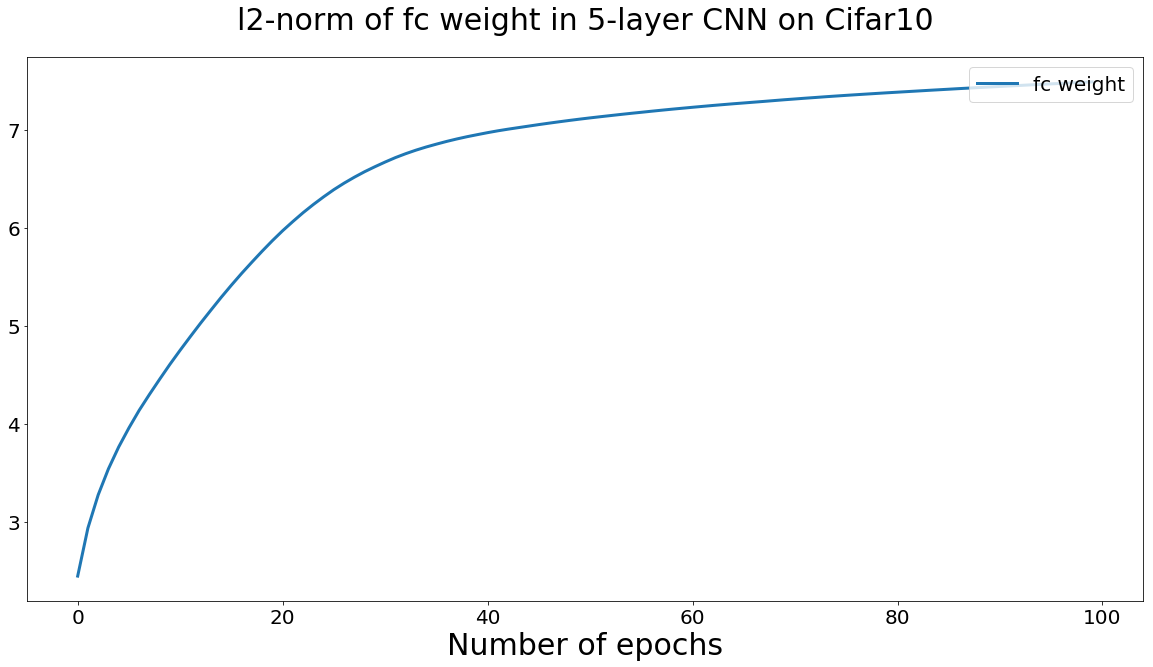

In [16]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, r'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log['train_loss'], linewidth=3, label='training')
    ax1.plot(log['test_loss'], linewidth=3, label='test')
    ax2.plot(log['train_error'], linewidth=3, label='training')
    ax2.plot(log['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log['margin'], linewidth=3, label='margin')
    ax5.plot(log['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss%d.png' % channels)
    fig2.savefig(result_dir + 'error%d.png' % channels)
    fig3.savefig(result_dir + 'conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'margin%d.png' % channels)
    fig5.savefig(result_dir + 'n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'fc_weight%d.png' % channels)


plot()
plt.show()


## Train Without batch normalization

In [8]:
# %% run the model without batch normalization
num_epochs = 100
channels = 100

# here use with_bn to control batch normalisation
model0 = basic_cnn.CNN(channels, 10, with_bn=False)

log0 = {'num_params': [],
       'train_loss': [],
       'train_error': [],
       'test_loss': [],
       'test_error': [],
       'w0': [], 'w1': [], 'w2': [],
       'w3': [], 'w4': [], 'w_fc': [],
       'margin': [], 'normalised_margin': []}

number_params = sum(p.numel() for p in model0.parameters() if p.requires_grad)
log0['num_params'].append(number_params)

if use_gpu:
    model0 = model0.cuda()

criterion = nn.CrossEntropyLoss()
optimizer0 = optim.SGD(model0.parameters(), lr=lr, weight_decay=weight_decay)

model0, log0 = train_model(model0, criterion, optimizer0, log0, num_epochs=num_epochs)


Epoch 1/100
----------
train Loss: 2.3014 Error: 0.8980 w4_norm: 0.3327 Margin: -0.1693 Norm_margin: -23.1172
test Loss: 2.2985 Error: 0.8842
Saving..
Epoch 2/100
----------
train Loss: 2.2841 Error: 0.8493 w4_norm: 0.3341 Margin: -1.4961 Norm_margin: -195.3909
test Loss: 2.2392 Error: 0.8142
Epoch 3/100
----------
train Loss: 2.1225 Error: 0.7716 w4_norm: 0.3395 Margin: -6.7597 Norm_margin: -758.1649
test Loss: 2.0020 Error: 0.7279
Epoch 4/100
----------
train Loss: 1.9356 Error: 0.7042 w4_norm: 0.3447 Margin: -7.0030 Norm_margin: -691.1843
test Loss: 1.8506 Error: 0.6761
Epoch 5/100
----------
train Loss: 1.8086 Error: 0.6551 w4_norm: 0.3504 Margin: -7.9578 Norm_margin: -692.7169
test Loss: 1.7332 Error: 0.6316
Epoch 6/100
----------
train Loss: 1.7140 Error: 0.6191 w4_norm: 0.3561 Margin: -8.1770 Norm_margin: -633.6398
test Loss: 1.6661 Error: 0.6041
Epoch 7/100
----------
train Loss: 1.6388 Error: 0.5924 w4_norm: 0.3618 Margin: -8.3454 Norm_margin: -578.4310
test Loss: 1.6090 Error

test Loss: 1.0638 Error: 0.3172
Epoch 58/100
----------
train Loss: 0.4122 Error: 0.1454 w4_norm: 0.7069 Margin: -10.0354 Norm_margin: -9.6421
test Loss: 1.1108 Error: 0.3256
Epoch 59/100
----------
train Loss: 0.3970 Error: 0.1394 w4_norm: 0.7156 Margin: -12.0849 Norm_margin: -10.7726
test Loss: 1.1001 Error: 0.3215
Epoch 60/100
----------
train Loss: 0.3850 Error: 0.1354 w4_norm: 0.7244 Margin: -10.7680 Norm_margin: -8.9019
test Loss: 1.1063 Error: 0.3229
Epoch 61/100
----------
train Loss: 0.3671 Error: 0.1302 w4_norm: 0.7333 Margin: -12.6945 Norm_margin: -9.7400
test Loss: 1.1557 Error: 0.3259
Saving..
Epoch 62/100
----------
train Loss: 0.3502 Error: 0.1232 w4_norm: 0.7425 Margin: -11.1931 Norm_margin: -7.9541
test Loss: 1.1737 Error: 0.3258
Epoch 63/100
----------
train Loss: 0.3373 Error: 0.1185 w4_norm: 0.7514 Margin: -11.4390 Norm_margin: -7.5530
test Loss: 1.2003 Error: 0.3232
Epoch 64/100
----------
train Loss: 0.3205 Error: 0.1128 w4_norm: 0.7606 Margin: -11.8917 Norm_margi

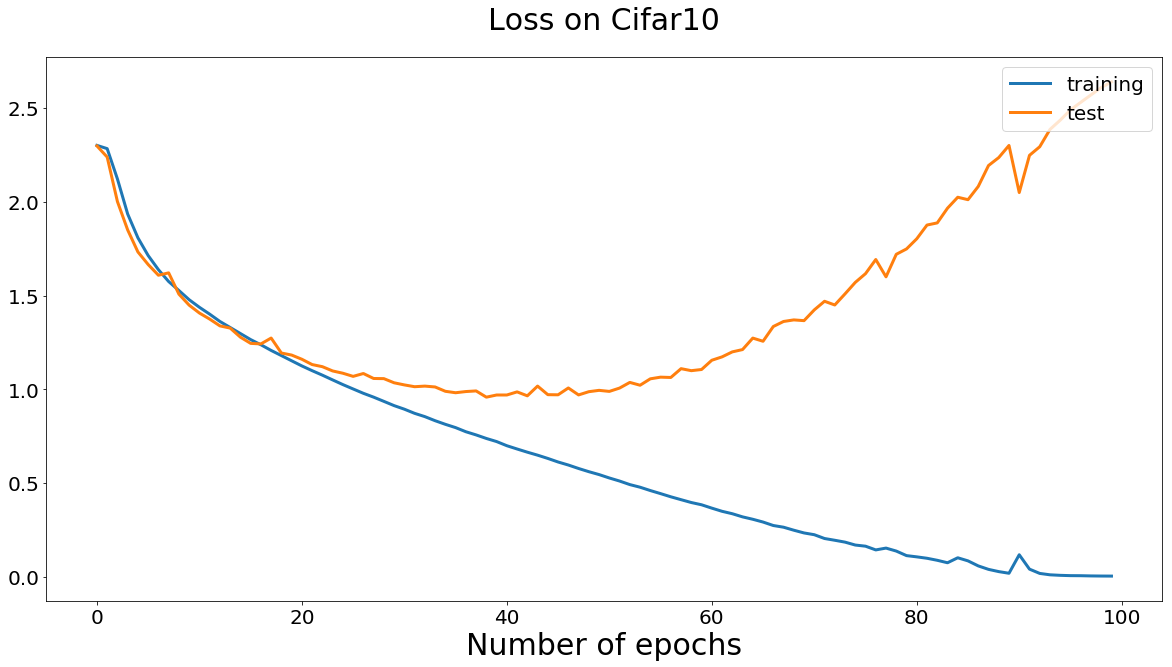

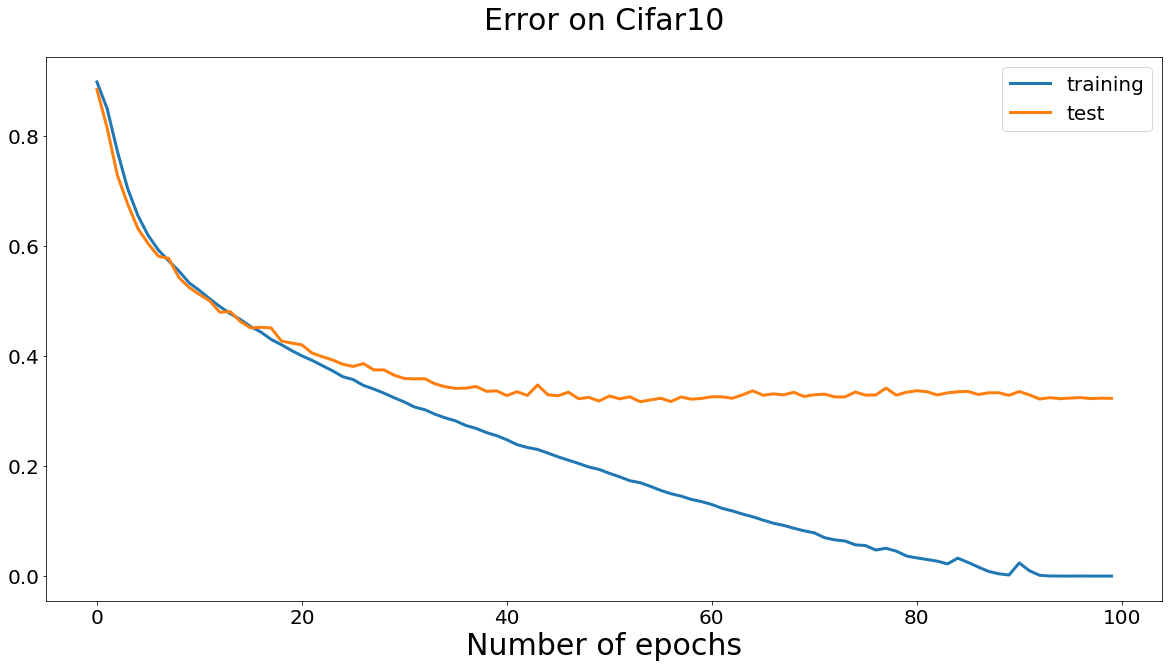

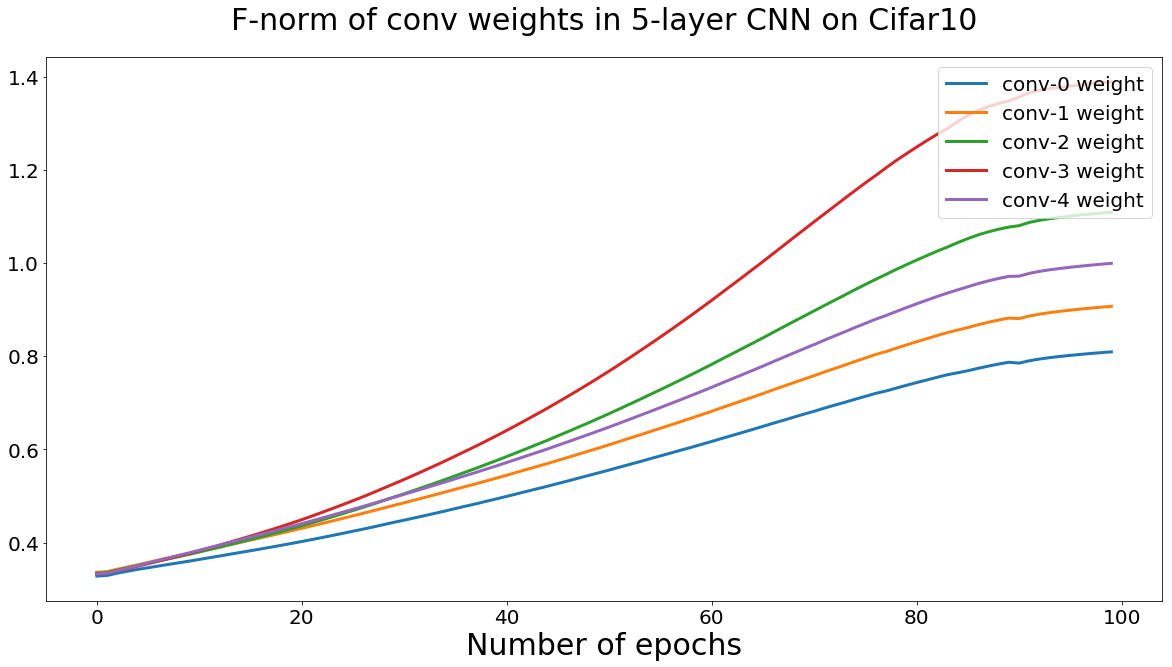

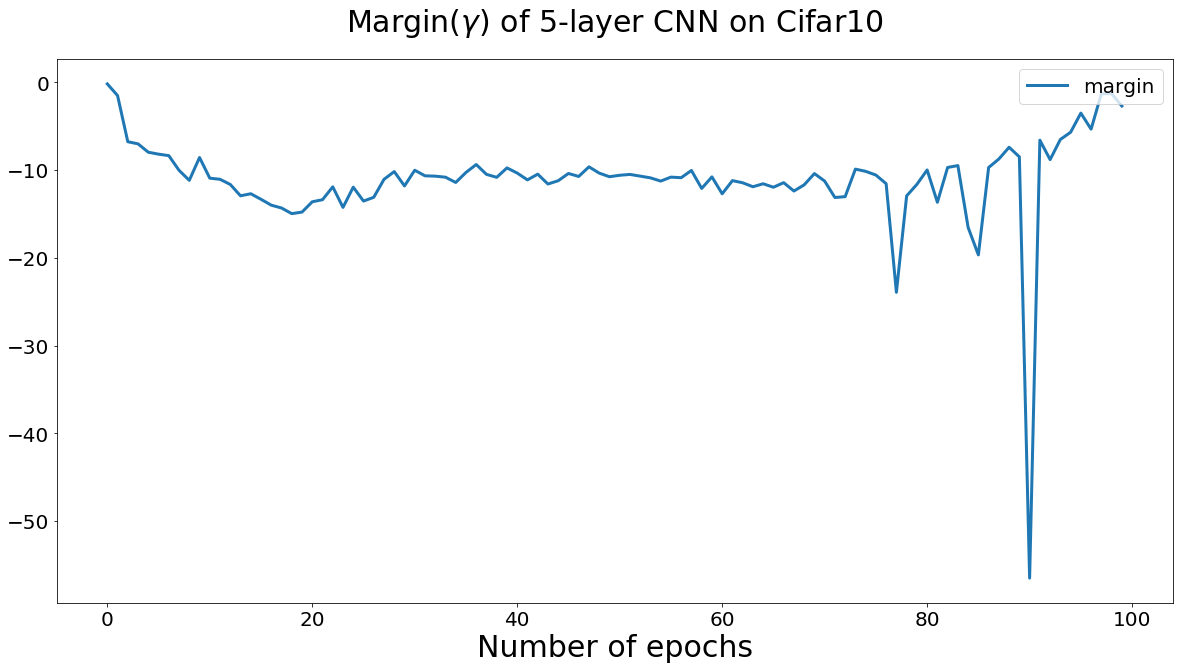

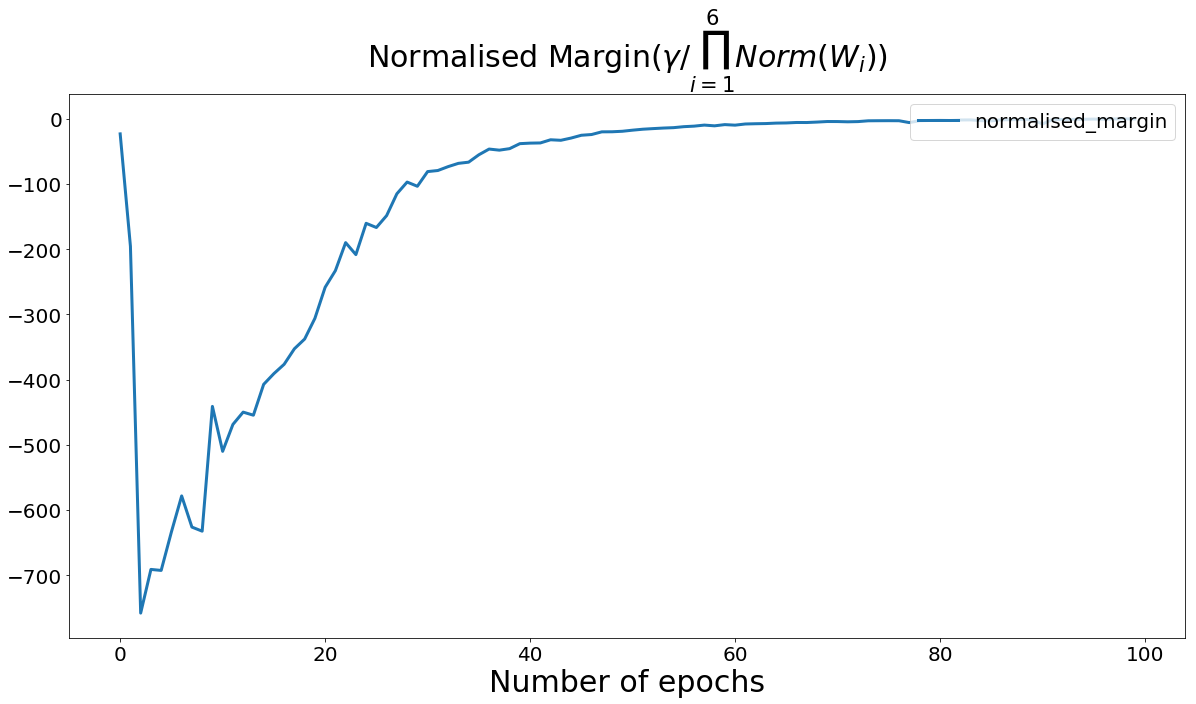

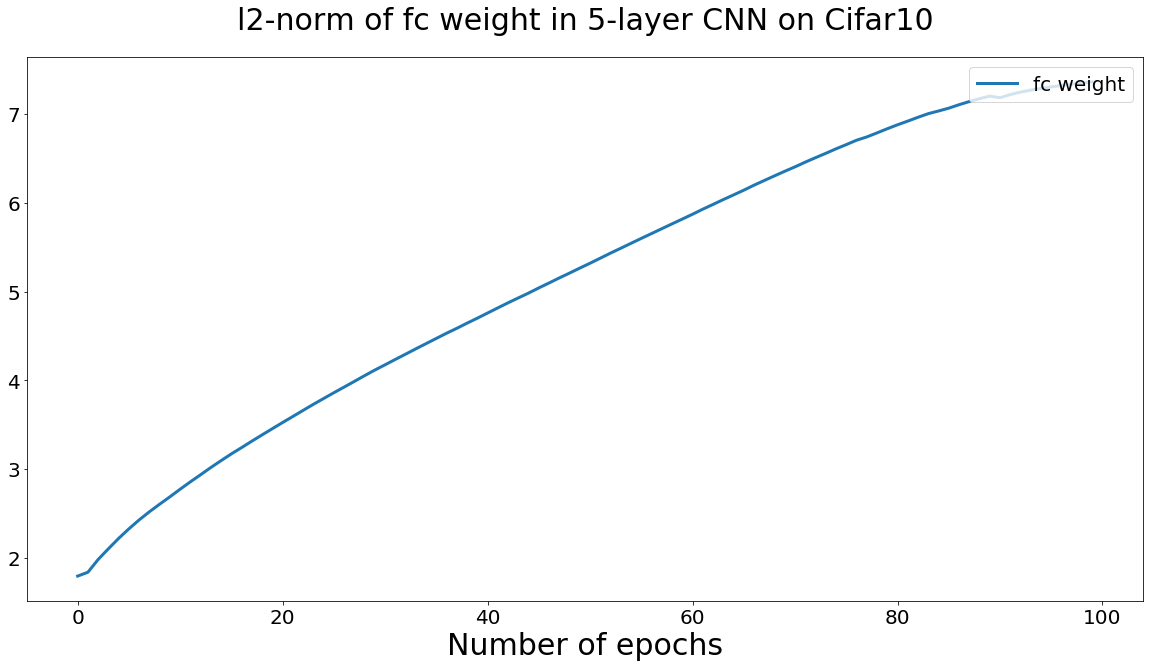

In [10]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log0['train_loss'], linewidth=3, label='training')
    ax1.plot(log0['test_loss'], linewidth=3, label='test')
    ax2.plot(log0['train_error'], linewidth=3, label='training')
    ax2.plot(log0['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log0['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log0['margin'], linewidth=3, label='margin')
    ax5.plot(log0['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log0['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'bn0_loss%d.png' % channels)
    fig2.savefig(result_dir + 'bn0_error%d.png' % channels)
    fig3.savefig(result_dir + 'bn0_conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'bn0_margin%d.png' % channels)
    fig5.savefig(result_dir + 'bn0_n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'bn0_fc_weight%d.png' % channels)


plot()
plt.show()


In [19]:
print('Finished.')

Finished.


So Batch Normalization here significantly speeds u